In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#for the sorting of the images
train_folders = sorted(glob('/content/drive/MyDrive/MangoDetection/train/*'))
print(train_folders)

['/content/drive/MyDrive/MangoDetection/train/anthacnose', '/content/drive/MyDrive/MangoDetection/train/black_soothy_mold', '/content/drive/MyDrive/MangoDetection/train/healthy', '/content/drive/MyDrive/MangoDetection/train/powdary_mildew']


In [ ]:
length  = len(train_folders)
print(length)

4


In [ ]:
#for the bgr to rgb 
#for the sizing of thee images and adjust to same size
def load_image(img_path):
  resize=True
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  #for fixing the axis and not rotate
  plt.axis('off')

In [ ]:
def show_leaf(image_paths):
  #list comprehesion
  images = [load_image(img) for img in image_paths]
  # pytorch built function
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  #for the iumage processing and studing the pixels and making the grid
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(16, 8))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [ ]:
for tf in train_folders:
  print(glob(f'{tf}/*.jpg'))

['/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0001.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0016.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0002.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0004.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0014.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0005.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0003.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0015.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0010.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0009.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0011.jpg', '/content/drive/MyDrive/MangoDetection/train/anthacnose/anthracnose-0008.jpg', '/content/drive/MyDrive/MangoDetection/train/anthac

<ipython-input-7-847ec12ed4e0>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.as_tensor(images)


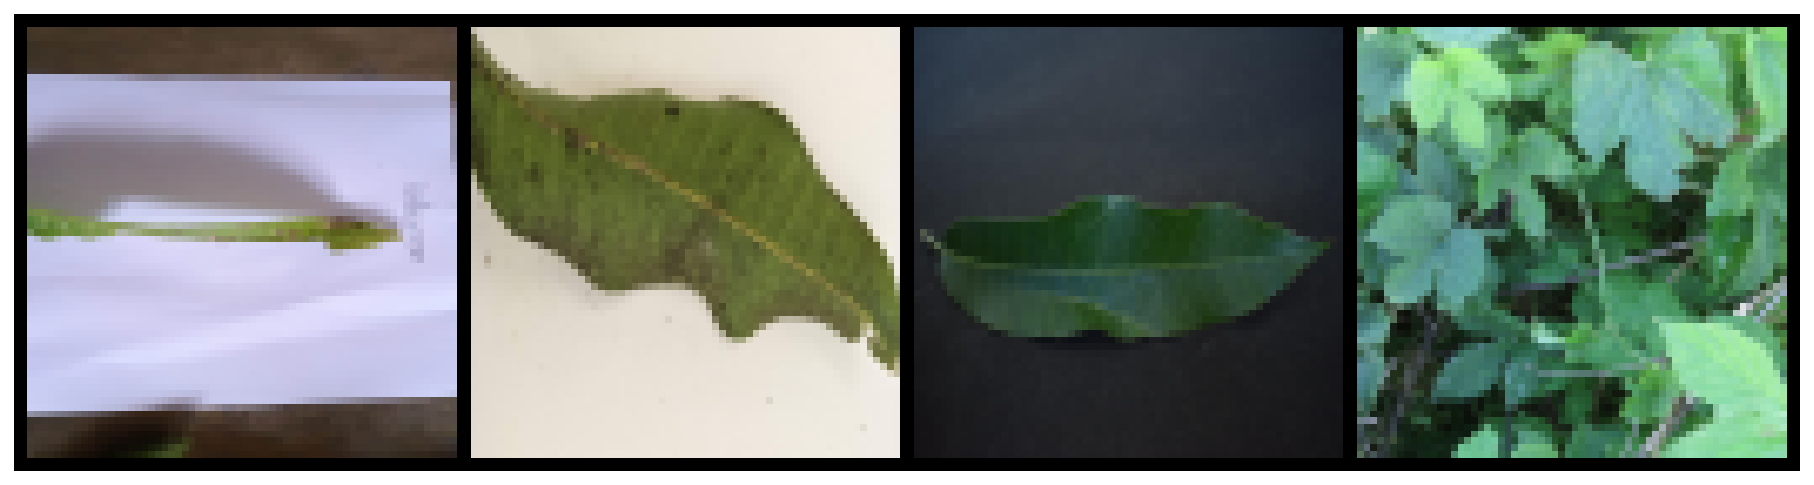

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*.jpg')) for tf in train_folders]
show_leaf(sample_images)

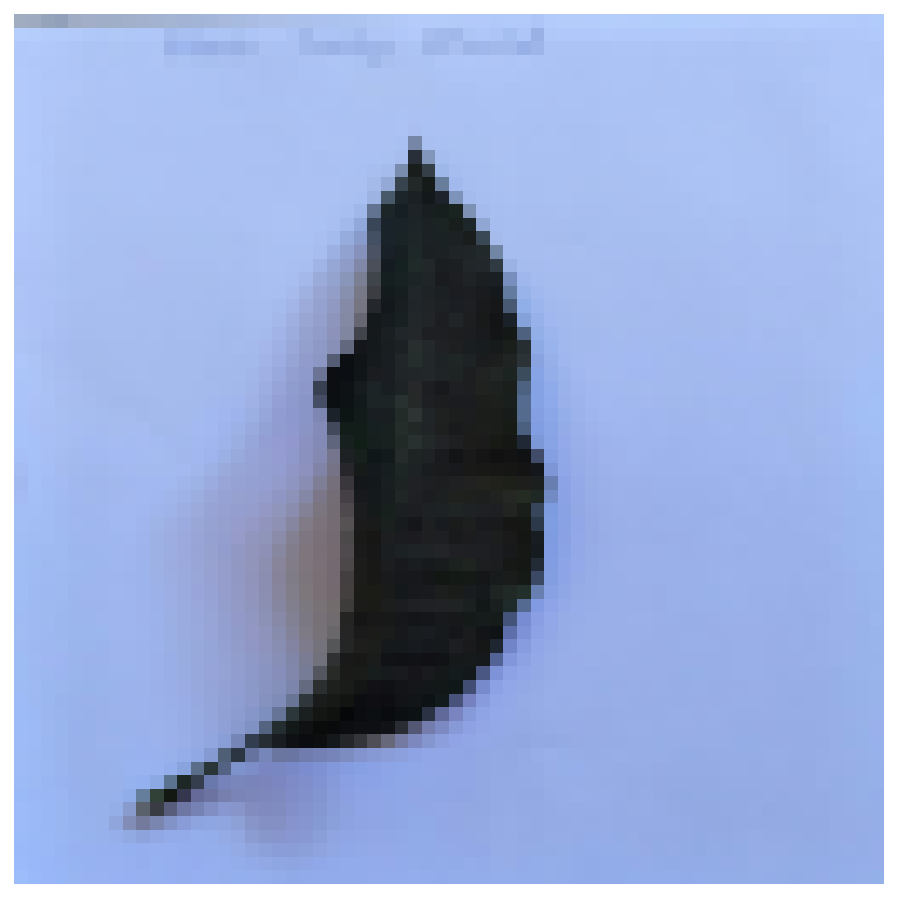

In [ ]:
#for the sorted series order
img_path = glob(f'{train_folders[1]}/*.jpg')[1]
show_image(img_path)

In [ ]:

class_names = ['anthacnose', 'black_soothy_mold','healthy','powdary_mildew']
class_indices=[0,1,2,3]

In [ ]:
DATA_DIR = Path('Mangofinal+')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  #for creating the nparray
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.jpg'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

anthacnose: 525
black_soothy_mold: 443
healthy: 104
powdary_mildew: 104


In [ ]:
#for the random data pre-proccesssing
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(size=(256, 256)),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=(256, 256)),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=(256, 256)),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=0) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 940, 'val': 116, 'test': 120}

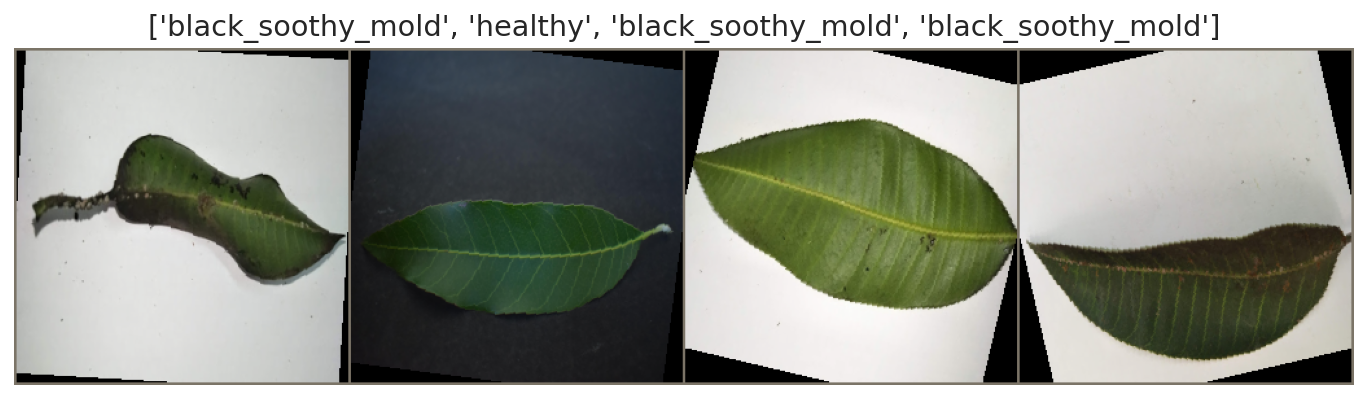

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#for the Same Sequence of the Serises of the input and ouput form one layer to another layer
class model(nn.Module):
  def __init__(self, num_classes= 4):
    super(model, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =1)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=7, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =1)
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.fc = nn.Linear(25*25*32, num_classes)
    

  def forward(self, x):
     #print(x.shape)
     out = self.layer1(x)
     #print(out.shape)
     out = self.layer2(out)
     #print(out.shape) 
     out = self.layer3(out)
     #print(out.shape)
     out = self.layer4(out)
     #print(out.shape)
     out = self.layer5(out)
     # print('layer 5 output: '+str(out.shape))
     out= out.reshape(out.size(0), -1)
     #print(out.shape) 
     out = self.fc(out)
     
     return out 

In [ ]:
model = model().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=15):

      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6)
      scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
      loss_fn = nn.CrossEntropyLoss().to(device)
      history = defaultdict(list)
      best_accuracy = 0

      for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
          model,
          data_loaders['train'],    
          loss_fn, 
          optimizer, 
          device, 
          scheduler, 
          dataset_sizes['train']
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
          model,
          data_loaders['val'],
          loss_fn,
          device,
          dataset_sizes['val']
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
          torch.save(model.state_dict(), 'best_model_state.bin')
          best_accuracy = val_acc

      print(f'Best val accuracy: {best_accuracy}')
      
      model.load_state_dict(torch.load('best_model_state.bin'))

      return model, history

In [ ]:
model, history = train_model(model, data_loaders, dataset_sizes, device)


Epoch 1/15
----------
Train loss 2.3479016497157366 accuracy 0.7170212765957447
Val   loss 0.35539104975759983 accuracy 0.8706896551724138

Epoch 2/15
----------
Train loss 0.4645098662598336 accuracy 0.8393617021276596
Val   loss 0.46909281620274074 accuracy 0.8362068965517241

Epoch 3/15
----------
Train loss 0.4465841097559067 accuracy 0.8595744680851064
Val   loss 0.2887477073176154 accuracy 0.9310344827586207

Epoch 4/15
----------
Train loss 0.34918824739239 accuracy 0.8957446808510638
Val   loss 0.2397824870743628 accuracy 0.896551724137931

Epoch 5/15
----------
Train loss 0.3505159336271042 accuracy 0.8787234042553191
Val   loss 0.24827594399966044 accuracy 0.9051724137931034

Epoch 6/15
----------
Train loss 0.3040645079142315 accuracy 0.8851063829787233
Val   loss 0.15324157993469772 accuracy 0.9568965517241379

Epoch 7/15
----------
Train loss 0.3384080479664609 accuracy 0.8851063829787233
Val   loss 0.12098389517130523 accuracy 0.9741379310344828

Epoch 8/15
----------
Tra

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

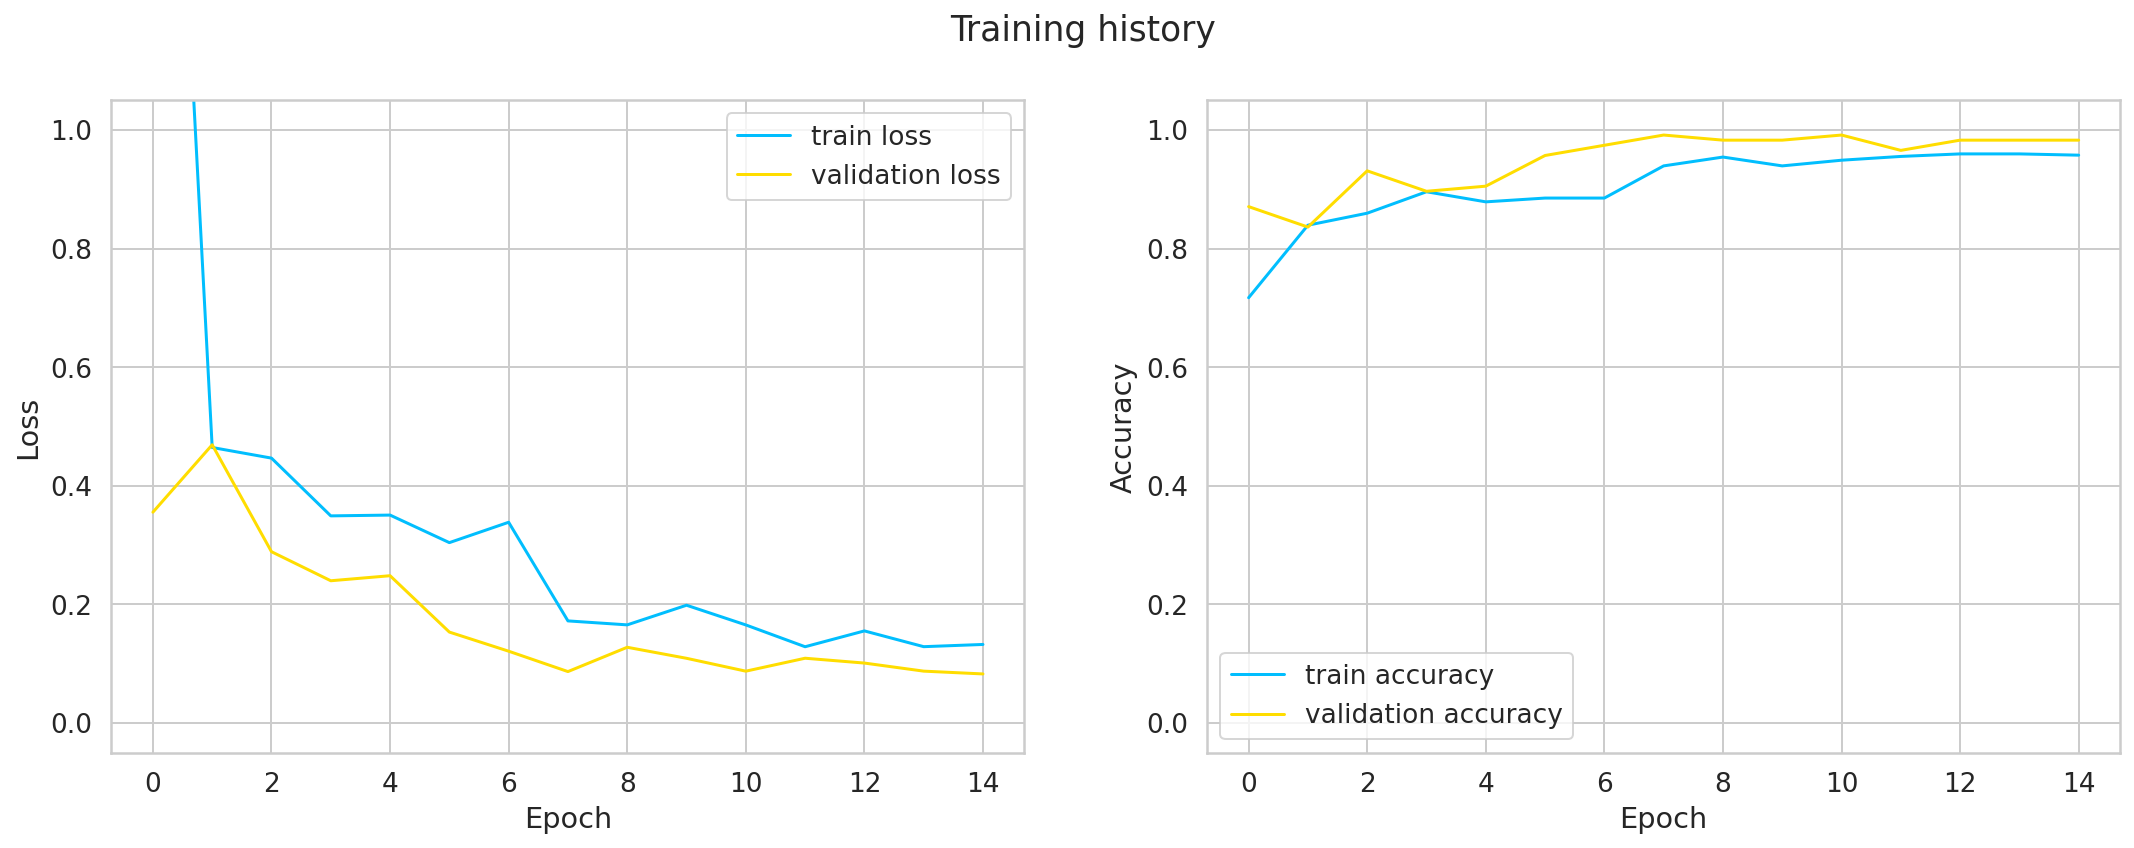

In [ ]:
plot_training_history(history)


In [ ]:
#Now We what we testing the model from the testing data
def show_predictions(model, class_names, n_images=8):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

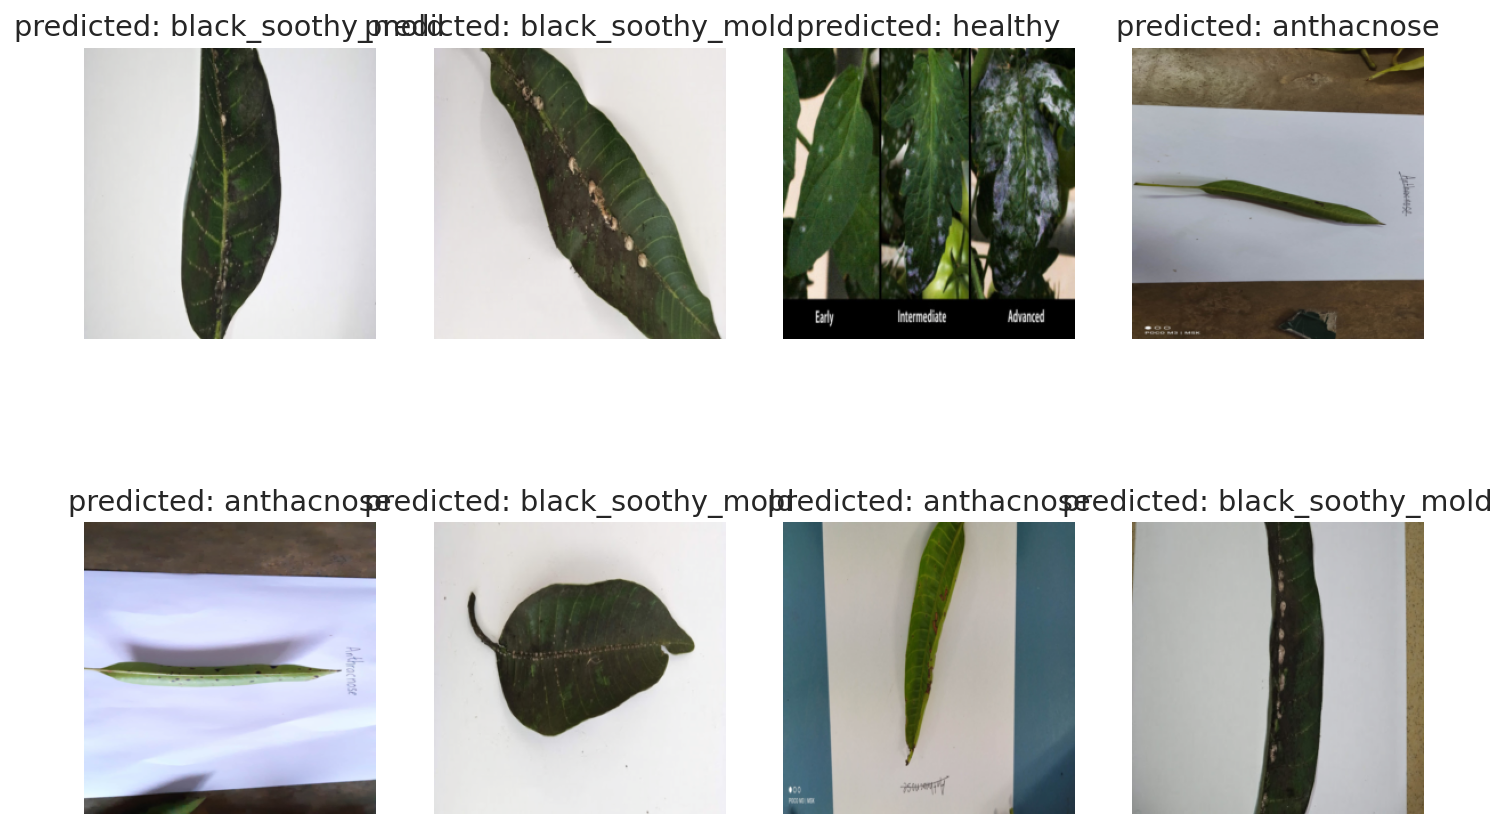

In [ ]:
show_predictions(model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_true = get_predictions(model, data_loaders['test'])

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

       anthacnose       0.94      0.92      0.93        53
black_soothy_mold       0.91      0.93      0.92        45
          healthy       0.85      1.00      0.92        11
   powdary_mildew       0.89      0.73      0.80        11

         accuracy                           0.92       120
        macro avg       0.90      0.90      0.89       120
     weighted avg       0.92      0.92      0.92       120



In [ ]:
import torch
mae_loss = torch.nn.L1Loss()
input = torch.Tensor.float(y_pred)
target = torch.Tensor.float(y_true)
output = mae_loss(input, target)
print('MAE:',output)

MAE: tensor(0.1083)


In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

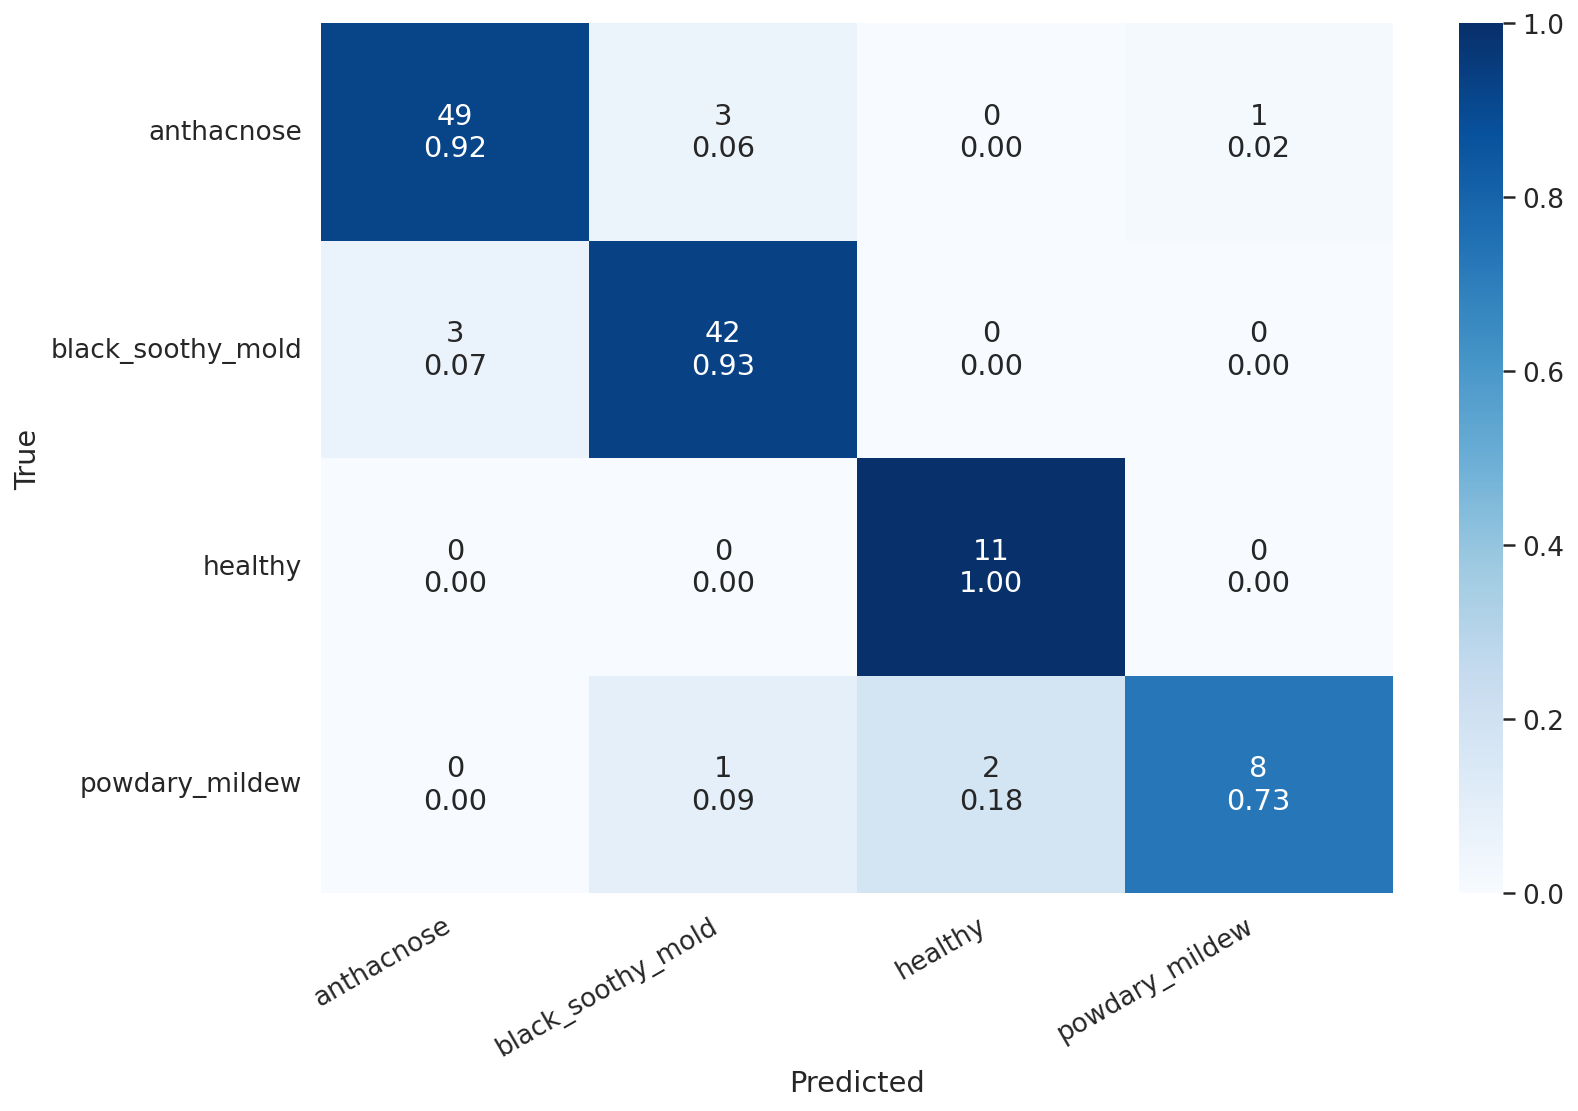

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
leaf= '/content/drive/MyDrive/MangoDetection/train/black_soothy_mold/black-soothy-mold-0002.jpg'

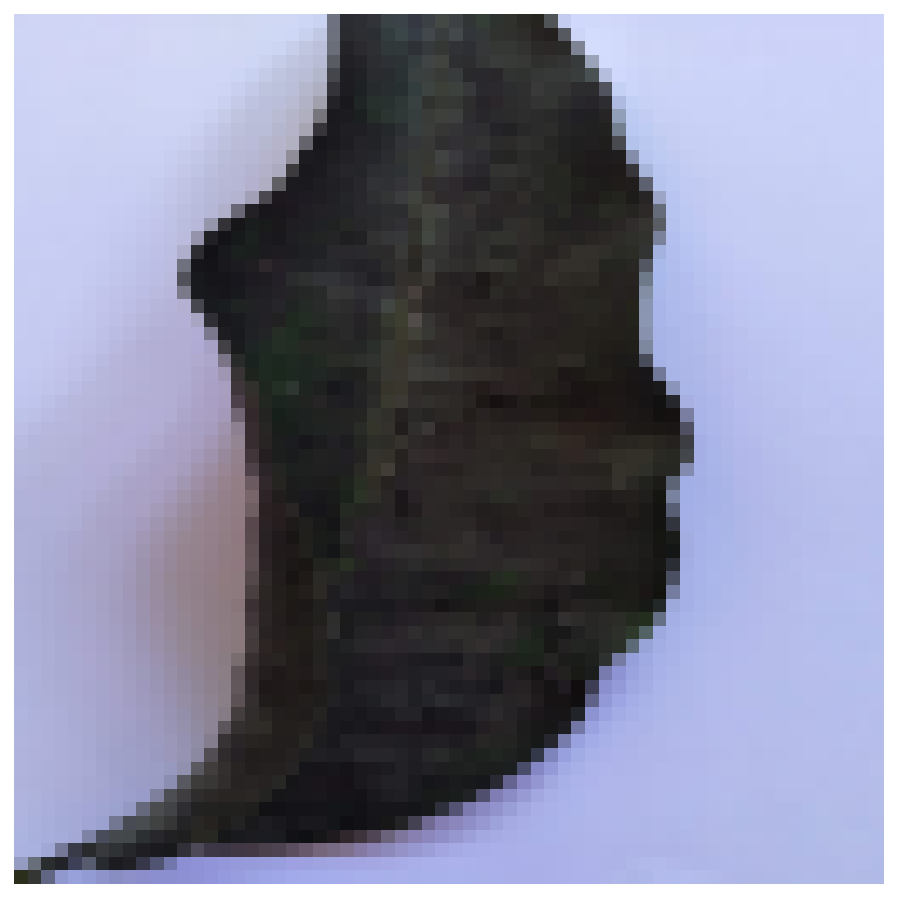

In [ ]:
show_image(leaf)

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(model, leaf)
print (pred)

[6.4733205e-05 9.9938858e-01 6.7114293e-06 5.4004462e-04]


In [ ]:

def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

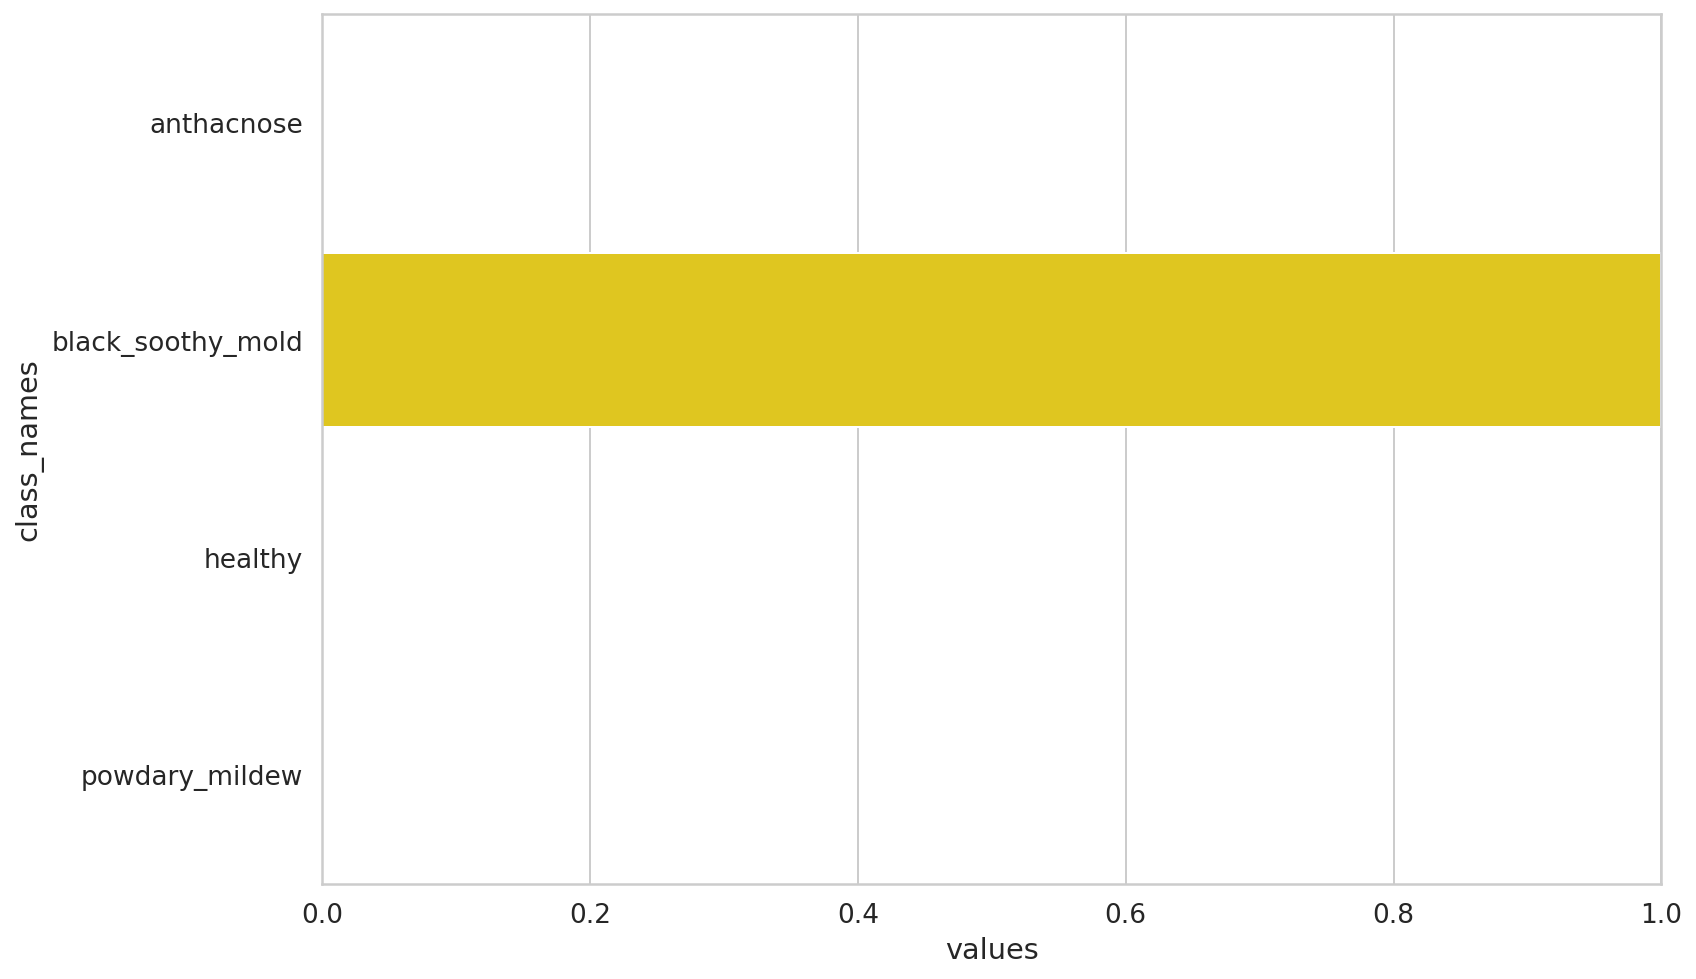

In [ ]:
show_prediction_confidence(pred, class_names)